### Importing the relevant packages
If the environment is correctly setup you should be able to sucessfully import the following packages.

In [1]:
import matplotlib.pyplot as plt
from gym import spaces
from tqdm import tqdm

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent, RussoAgent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn

%matplotlib inline

### Loading the environment object and running it
In the following cell we instanciate a dynamical model (of the `ModelDynamics` class) that implements the epidemic simulation. The simulation parameters are set by the config file that we load (here `switzerland.yaml`). We then demonstrate how one can query the list of cities from the dynamical model and how one can plot the map on which the simulation will happen. 

In [2]:
dyn = ModelDynamics('config/switzerland.yaml')   # load the switzerland map


# Question 4.2

In [3]:
def action_preprocessor(a:torch.Tensor, dyn:ModelDynamics):
    keys = ['confinement', 'isolation', 'hospital', 'vaccinate']
    # Create a dictionnary where values of 'a' are transformed in bool and assigned to a key 
    action = dict(zip(keys, np.array(a, dtype=bool).T))
        
    return action
    
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    infected = np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    dead = np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    infected = infected**(1/4)
    dead = dead**(1/4)
    return torch.Tensor(np.stack((infected, dead))).unsqueeze(0)

In [4]:
action_space        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [5]:
env = Env(  dyn,
            action_space=action_space,
            observation_space=observation_space,
            action_preprocessor=action_preprocessor,
            observation_preprocessor=observation_preprocessor
            )

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random

class FactorizedQ(Agent):
    def __init__(self,  env:Env, memory_size=20000 ,learning_rate = 0.005, discount_factor = 0.9):
        """
        Example agent implementation. Just picks a random action at each time step.
        """
        self.env = env
        self.memory = deque(maxlen=memory_size)
        self.model = self.create_model()
        self.target_model = self.create_model()
        self.update_target_model()
        self.optimizer = optim.Adam(self.model.parameters(), lr = learning_rate)
        self.loss_fn = nn.HuberLoss()
        self.gamma = discount_factor
        
    
    def create_model(self):
        obs_dim = self.env.observation_space.shape[0]*self.env.observation_space.shape[1]*self.env.observation_space.shape[2]
        action_dim = self.env.action_space.shape[0]*2
        model = nn.Sequential(
            nn.Linear(obs_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, action_dim)
        )
        return model

    def update_target_model(self):
        self.target_model.load_state_dict(self.model.state_dict())

    def load_model(self, savepath):
        # This is where one would define the routine for loading a pre-trained model
        pass

    def save_model(self, savepath):
        # This is where one would define the routine for saving the weights for a trained model
        pass

    def optimize_model(self, batch_size):
        if len(self.memory) < batch_size:
            return
        batch = random.sample(self.memory, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        batch_states = torch.stack(states)
        batch_actions = np.array(actions)
        batch_actions = torch.LongTensor(actions)
        batch_rewards = torch.stack(rewards).squeeze()
        batch_next_states = torch.stack(next_states).squeeze(1)
        batch_dones = torch.LongTensor(np.array(dones).astype(int))
        
        curr_Q = self.model(batch_states).reshape((batch_size, self.env.action_space.shape[0], 2))
        #Compute the actual Q summing the qvalues corresponding to the actions taken
        curr_Q = curr_Q[np.arange(curr_Q.shape[0])[:, None], np.arange(curr_Q.shape[1]), batch_actions].sum(-1)
        # Compute the best Q for this state summing over the max Qa
        next_Q = self.target_model(batch_next_states)
        next_Q = next_Q.reshape((batch_size, self.env.action_space.shape[0], 2)).max(-1)[0].sum(-1)
        
        target_Q = batch_rewards + (1 - batch_dones) * self.gamma * next_Q # gamma is the discount factor
        loss = self.loss_fn(curr_Q, target_Q)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
    
    def reset(self,):
        # This should be called when the environment is reset
        pass
    
    def act(self, obs):
        # this takes an observation and returns 4 actions
        # the action space can be directly sampled from the env
        state = obs[0,:2].flatten()
        if np.random.random() < self.epsilon: # Exploration
            return self.env.action_space.sample()
        else: # Exploitation
            state = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                action_values = self.model(state)

                # Reshape action_values to gather actions [[a_conf=TRUE, a_conf=FALSE], ...]
                action_values = torch.reshape(action_values, (4,2))
            
            # Return an array of size 4 with binary choice [conf, isol, hosp, vacc]
            return torch.argmax(action_values, dim = 1).tolist()

    def remember(self, state, action, reward, next_state, done):
        #print('Remember :', (state, action, reward, next_state, done))
        #print('State :', state)
        #print('Action :', action)
        #print('Reward :', reward)
        #print('Next state :', next_state)
        #print('Done :', done)
        state = state[0,:2].flatten()
        next_state = next_state[0,:2].flatten()
        self.memory.append((state, action, reward, next_state, done))

In [7]:


N_EPISODES = 500
EVAL_INTERVAL = 50
NUM_EVAL_EPISODES = 20
TARGET_UPDATE_INTERVAL = 5  # Update target network every 5 episodes

BATCH_SIZE = 2048
BUFFER_SIZE = 20000
LR = 1e-5   # learning rate
GAMMA = 0.9 # discount factor

epsilon_start = 0.7
epsilon_end = 0.2
epsilon_decay = 995.  # 0.995

input_shape = 126  # 2*9*7
action_size = 8  # binary action space
seed = 0  # or any other seed you want to use for reproducibility

agent = FactorizedQ(env, memory_size = BUFFER_SIZE, learning_rate=LR, discount_factor=GAMMA)  # Assume you've defined input_shape, action_size, seed
agent.epsilon = epsilon_start

log = {
    'Episode': [i + 1 for i in range(N_EPISODES)],
    'conf_days': [],
    'R_cumul': [],
    'N_deaths': [],
    'eval_trace': []
}

best_eval_reward = -np.inf

""" Run several simulations """
for i in tqdm(range(N_EPISODES)):
    finished = False
    obs, info = env.reset()
    N_confin = 0
    R_cumul = 0
    
    if i % TARGET_UPDATE_INTERVAL == 0:
        agent.update_target_model()

    while not finished:
        action = agent.act(obs)
        next_obs, R, finished, info = env.step(action)

        R_cumul += R
        N_confin += info.action['confinement'] * 7

        # Store the transition in memory
        agent.remember(obs, action, R, next_obs, finished)

        # Train the model
        agent.optimize_model(BATCH_SIZE)  

        obs = next_obs

        if finished:
            break
            
    # Decay epsilon
    agent.epsilon = max(epsilon_end, epsilon_start * (N_EPISODES-i)/N_EPISODES)

    log['conf_days'].append(N_confin)
    log['R_cumul'].append(R_cumul.numpy()[0])
    log['N_deaths'].append(info.total.dead)

    # Evaluation and logging
    if i % EVAL_INTERVAL == 0 or (i == N_EPISODES - 1 and N_EPISODES % EVAL_INTERVAL != 0):
        eval_rewards = []
        for idx in range(NUM_EVAL_EPISODES):
            obs, _ = env.reset()
            episode_reward = 0
            done = False
            while not done:
                action = agent.act(obs)  # No exploration
                obs, reward, done, _ = env.step(action)
                #print('Reward :', idx ,reward)
                episode_reward += reward
            eval_rewards.append(episode_reward)

        eval_rewards = [reward.item() for reward in eval_rewards]
        avg_eval_reward = np.mean(eval_rewards)
        log['eval_trace'].append(avg_eval_reward)
        print(f"Episode {i + 1}, Avg Eval Reward: {avg_eval_reward}")

        # Save the best model
        if avg_eval_reward > best_eval_reward:
            best_eval_reward = avg_eval_reward
            torch.save(agent.model.state_dict(), 'best_model.pt')  # Save the best model


  0%|          | 1/500 [00:05<44:30,  5.35s/it]

Episode 1, Avg Eval Reward: -168.06928958892823


 10%|█         | 51/500 [00:23<13:13,  1.77s/it]

Episode 51, Avg Eval Reward: -171.64644050598145


 14%|█▎        | 68/500 [00:27<01:50,  3.90it/s]/var/folders/9y/ryc1xybn5gbczjsb6wzyvwr40000gn/T/ipykernel_75324/2705060964.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:248.)
  batch_actions = torch.LongTensor(actions)
 20%|██        | 101/500 [00:46<12:58,  1.95s/it]

Episode 101, Avg Eval Reward: -198.35233383178712


 30%|███       | 151/500 [01:14<11:30,  1.98s/it]

Episode 151, Avg Eval Reward: -176.9573459625244


 40%|████      | 201/500 [01:41<09:52,  1.98s/it]

Episode 201, Avg Eval Reward: -158.00651721954347


 50%|█████     | 251/500 [02:09<08:13,  1.98s/it]

Episode 251, Avg Eval Reward: -186.8953369140625


 60%|██████    | 301/500 [02:37<06:36,  1.99s/it]

Episode 301, Avg Eval Reward: -131.25974769592284


 70%|███████   | 351/500 [03:05<04:58,  2.01s/it]

Episode 351, Avg Eval Reward: -87.56728692054749


 80%|████████  | 401/500 [03:33<03:17,  1.99s/it]

Episode 401, Avg Eval Reward: -38.77863569259644


 90%|█████████ | 451/500 [04:01<01:37,  2.00s/it]

Episode 451, Avg Eval Reward: -72.06839275360107


100%|██████████| 500/500 [04:24<00:00,  1.89it/s]


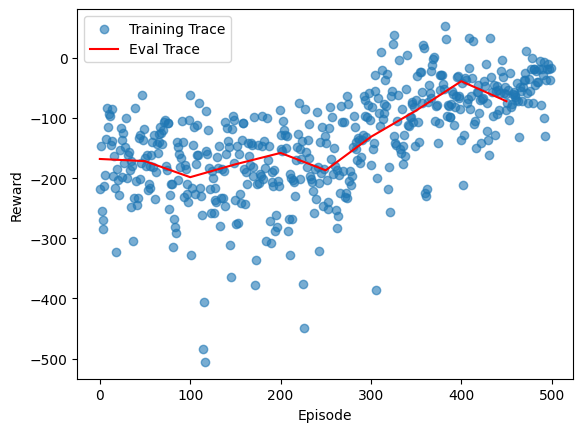

In [10]:
import matplotlib.pyplot as plt

# Extract rewards from log
training_rewards = log['R_cumul']
eval_rewards = log['eval_trace']

# Generate x values
x_train = range(len(training_rewards))
x_eval = range(0, len(training_rewards), EVAL_INTERVAL)

# Create new figure
plt.figure()

# Plot training trace
plt.scatter(x_train, training_rewards, label='Training Trace', alpha=0.6)

# Plot evaluation trace
plt.plot(x_eval, eval_rewards, label='Eval Trace', color='red')

# Add labels and legend
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()

# Show the plot
plt.show()


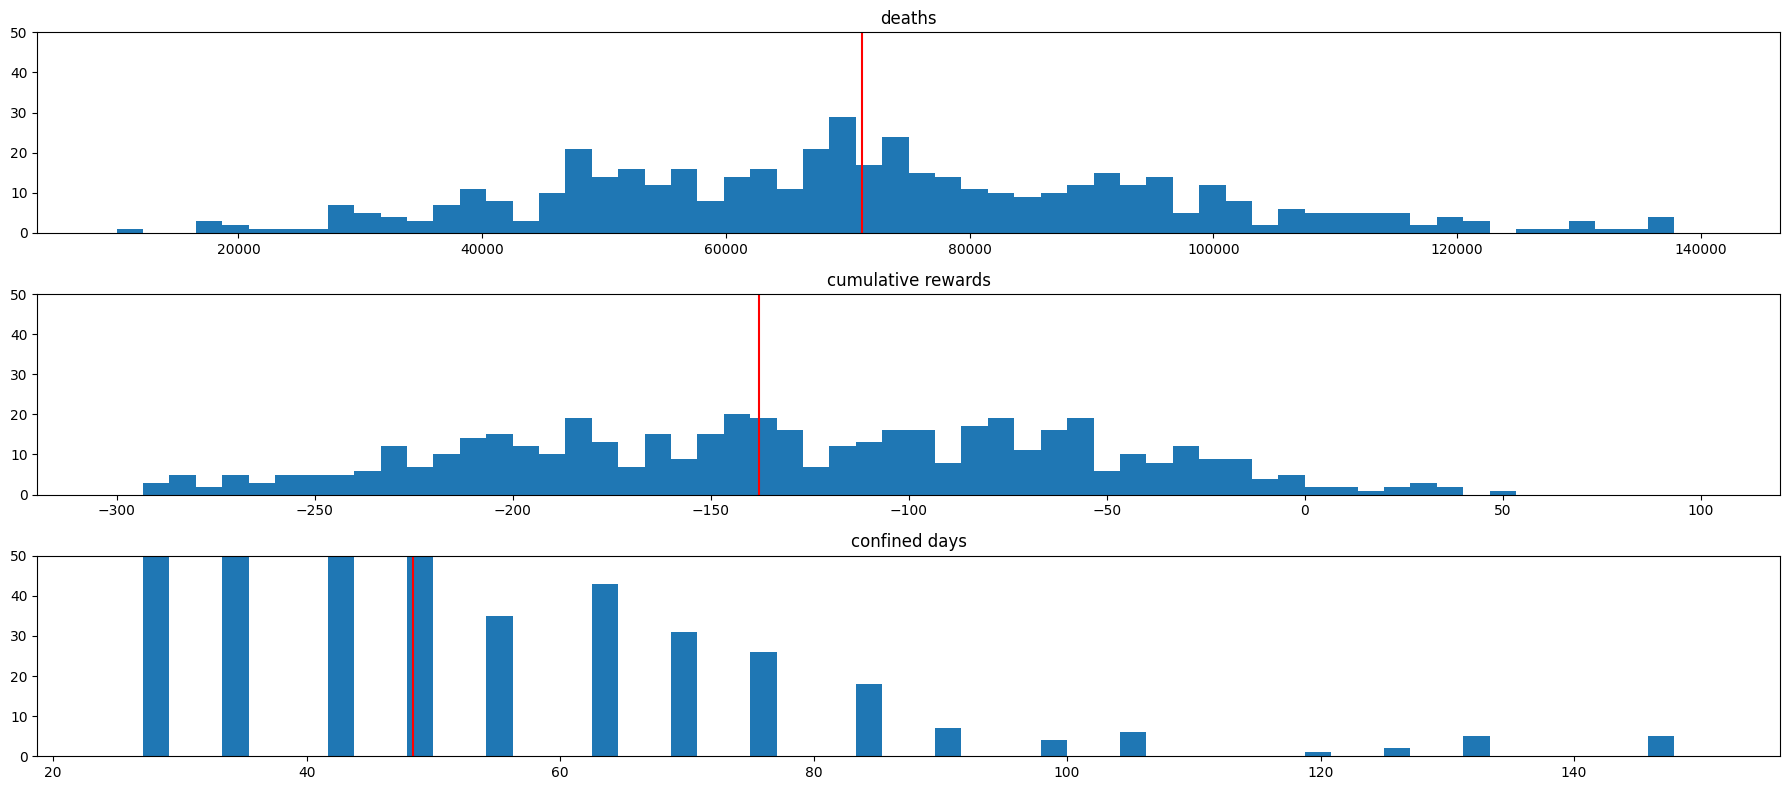

Average death number: 71156.804
Average number of confined days: 48.426
Average number of isolation days: 48.426
Average cumulative reward: -137.7611846923828
Maximum cumulative rewards: 53.167396545410156, corresponding to 77 days of confinement and resulting in 74592 deaths.


In [15]:
deaths = np.array(log['N_deaths'])
rewards = np.array(log['R_cumul'])
conf_days = np.array(log['conf_days'])


""" Plot example """
fig, ax = plt.subplots(3,1,figsize=(18,8))
def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (10000,140000)
    elif title == 'cumulative rewards': 
        x_range = (-300,100)
    elif 'days' in title:
        x_range = (25,150)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)
hist_avg(ax[0], deaths,'deaths')
hist_avg(ax[1], rewards,'cumulative rewards')
hist_avg(ax[2], conf_days,'confined days')
fig.tight_layout()
plt.show()

""" Print example """
print(f'Average death number: {np.mean(deaths)}')
print(f'Average number of confined days: {np.mean(conf_days)}')
print(f'Average number of isolation days: {np.mean(conf_days)}')
print(f'Average cumulative reward: {np.mean(rewards)}')
print(f'Maximum cumulative rewards: {np.amax(rewards)}, corresponding to {conf_days[np.argmax(reward)]} days of confinement and resulting in {deaths[np.argmax(reward)]} deaths.')

# TESTS

In [ ]:
action_space        =   spaces.MultiBinary(4)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

In [ ]:
a  = torch.Tensor(np.random.randint(0, 10, size=8).reshape((4,2)))
print(torch.argmax(a, dim = 1).tolist())
print(a)

49

In [ ]:
actions = {
        'confinement': False, 
        'isolation': False, 
        'hospital': False, 
        'vaccinate': False,
    }

action_taken = [0,0,1,1]

action_taken = np.array(action_taken, dtype = bool)
for v in actions.values():
    v

In [ ]:

action

In [ ]:
batch = random.sample(agent.memory, 64)
states, actions, rewards, next_states, dones = zip(*batch)


In [ ]:
batch_states = torch.stack(states)
batch_actions = np.array(actions)
batch_actions = torch.LongTensor(actions)
batch_rewards = torch.stack(rewards)
batch_next_states = torch.stack(next_states).squeeze(1)
batch_dones = torch.LongTensor(np.array(dones).astype(int))


print(batch_states.shape,batch_actions.shape,batch_rewards.shape,batch_next_states.shape)
print(batch_rewards)

In [ ]:
batch_rewards.squeeze().shape

In [ ]:
curr_Q = agent.model(batch_states).reshape((64, agent.env.action_space.shape[0], 2))
#Compute the actual Q summing the qvalues corresponding to the actions taken
curr_Q = curr_Q[np.arange(curr_Q.shape[0])[:, None], np.arange(curr_Q.shape[1]), batch_actions].sum(-1)
# Compute the best Q for this state
next_Q = agent.target_model(batch_next_states)
next_Q = next_Q.reshape((64,4,2)).max(-1)[0].sum(-1)
batch_rewards = batch_rewards.squeeze()
target_Q = batch_rewards + (1 - batch_dones) * 0.9 * next_Q # 0.9 is the discount factor

In [ ]:
print(curr_Q.shape)
print(next_Q.shape)
print(batch_dones.shape)
print(batch_rewards.shape)
print(target_Q.shape)
        
loss = agent.loss_fn(curr_Q, target_Q)
print(loss)

In [ ]:
target_Q.detach().shape

In [ ]:
next_Q.reshape((64,4,2)).max(-1)[0].sum(-1)

In [ ]:
q2.gather(1, batch_actions.unsqueeze(-1)).squeeze(-1)
q2[np.arange(q2.shape[0])[:, None], np.arange(q2.shape[1]), batch_actions]